In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for dirname, _, filenames in os.walk('/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images'):
    for filename in filenames:
        count+=1
print(count)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

12256


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
batch_size = 32
img_height = 224
img_width = 224

import os
train_dir = ""
for dirname, _, filenames in os.walk('/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/train'):
    print(os.path.join(dirname))
    train_dir = os.path.join(dirname)
    break
print(train_dir)

val_dir = ""
for dirname, _, filenames in os.walk('/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/val'):
    print(os.path.join(dirname))
    val_dir = os.path.join(dirname)
    break
print(val_dir)

/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/train
/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/train
/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/val
/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/val


In [4]:
import pathlib
train_dir = pathlib.Path(train_dir)
images = list(train_dir.glob('*/*.jpg'))
train_image_count = len(images)
print("Train Images - ", train_image_count)

val_dir = pathlib.Path(val_dir)
images = list(val_dir.glob('*/*.jpg'))
val_image_count = len(images)
print("Validation Images - ", val_image_count)

Train Images -  9804
Validation Images -  2452


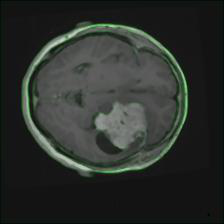

In [5]:
#1 - Meningioma , 2 - Glioma, 3 - Pitutary
Meningioma = list(train_dir.glob('1/*'))
PIL.Image.open(str(Meningioma[0]))


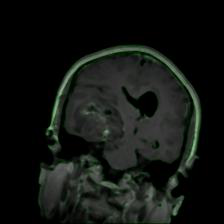

In [6]:
Glioma = list(val_dir.glob('2/*'))
PIL.Image.open(str(Glioma[0]))

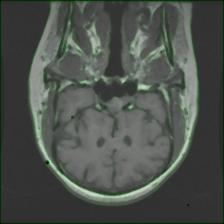

In [7]:
Pitutary = list(train_dir.glob('3/*'))
PIL.Image.open(str(Pitutary[0]))

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode= 'categorical', 
  crop_to_aspect_ratio=True )

Found 9804 files belonging to 3 classes.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode= 'categorical',
  crop_to_aspect_ratio= True )

Found 2452 files belonging to 3 classes.


In [10]:
class_names = train_ds.class_names
classes = ["Meningioma","Glioma" ,"Pitutary"]
class_names

['1', '2', '3']

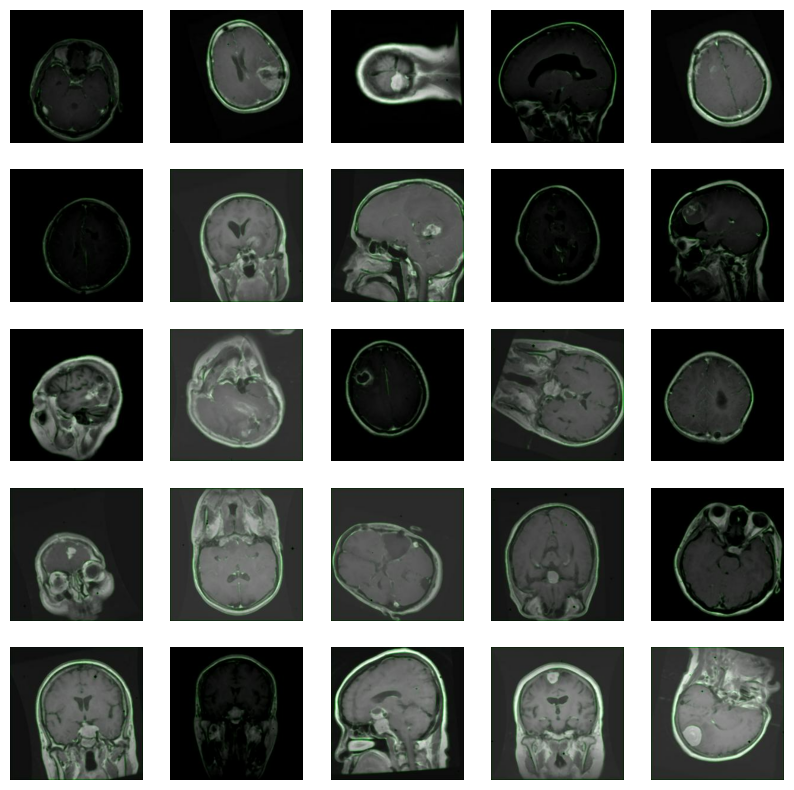

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(classes[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 3)


In [13]:
for _, labels in train_ds.take(1):
    print(labels)

tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(32, 3), dtype=float32)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width,3)
    )

94765736/94765736 [==============================] - 4s 0us/step


In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = keras.Sequential( [
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3)
])
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
print(prediction_batch[0])

(32, 7, 7, 2048)
(32, 2048)
(32, 3)
tf.Tensor([-0.9205148  1.3267767  2.456221 ], shape=(3,), dtype=float32)


In [19]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [20]:
inputs = tf.keras.Input(shape=(img_height, img_width,3) )
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0     

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.experimental.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
initial_epochs = 20
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
307/307 [==============================] - 30s 84ms/step - loss: 0.8699 - accuracy: 0.6779 - val_loss: 0.4194 - val_accuracy: 0.8226
Epoch 2/20
307/307 [==============================] - 22s 73ms/step - loss: 0.5578 - accuracy: 0.7860 - val_loss: 0.3302 - val_accuracy: 0.8577
Epoch 3/20
307/307 [==============================] - 22s 73ms/step - loss: 0.4731 - accuracy: 0.8183 - val_loss: 0.3190 - val_accuracy: 0.8646
Epoch 4/20
307/307 [==============================] - 22s 73ms/step - loss: 0.4441 - accuracy: 0.8261 - val_loss: 0.3040 - val_accuracy: 0.8760
Epoch 5/20
307/307 [==============================] - 22s 72ms/step - loss: 0.4224 - accuracy: 0.8368 - val_loss: 0.2916 - val_accuracy: 0.8797
Epoch 6/20
307/307 [==============================] - 22s 72ms/step - loss: 0.4067 - accuracy: 0.8432 - val_loss: 0.3177 - val_accuracy: 0.8715
Epoch 7/20
307/307 [==============================] - 22s 73ms/step - loss: 0.3932 - accuracy: 0.8473 - val_loss: 0.2882 - val_accuracy:

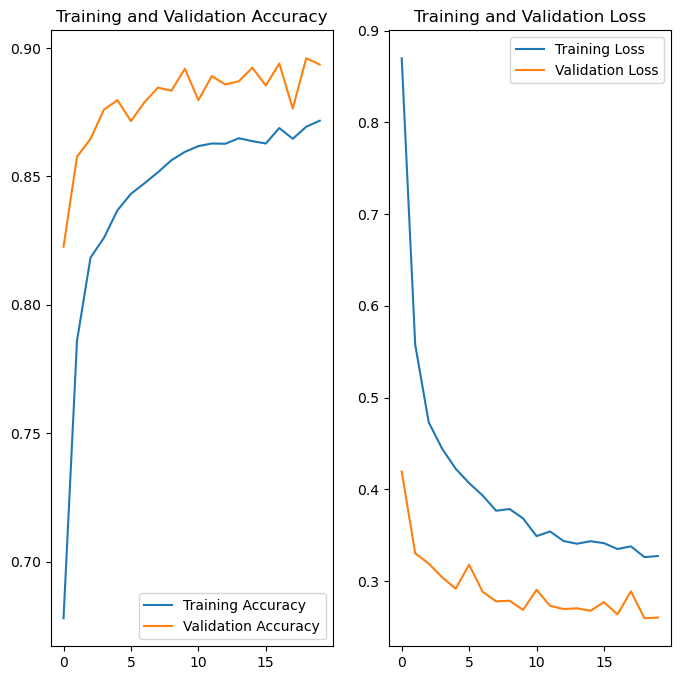

In [24]:
#plot for model trained with adam optimizer , i_epoch = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#saving the entire Model
model.save("/kaggle/working/BCCv4")